# Plan and Execute

This notebook is a follow along of the [Plan and Execute](https://github.com/langchain-ai/langgraph/blob/main/examples/plan-and-execute/plan-and-execute.ipynb) notebook from LangChain.

## Setup

First we need to install the packages required. See the `conda.yaml` file for the full list of dependencies. Be sure to activate it as the Jupyter kernel.

```bash
conda env create -f conda.yaml
conda activate langchain
```

## Environment Setup

First we ensure environment keys are set correctly.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Tools

The example uses the Tavily search tool as a tool, but other tools should work. Note that tools is a list of tools.

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

## Execution Agent

You can have more than one execution agent. These will be called by the full graph after the planner.

In [3]:
from langchain_core.prompts import (
    ChatPromptTemplate,
)  # The example pulls an object from their hub, but we can build one instead.

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

In [4]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_openai_functions_agent

# Create the llm object and choose the model
llm = ChatOpenAI(model="gpt-4-turbo")
# Construct the runnable
agent_runnable = create_openai_functions_agent(llm, tools, prompt)

> **Note** The `create_openai_functions_agent` takes the tools and converts them to OpenAI Functions. It also creates a sequence out of the a RunnablePassthrough, the prompt, the llm bound with the tools (as functions), and then the `OpenAIFunctionsOutputParser` which will parse the output of the OpenAI function into `AgentAction` or `AgentFinish`.

In [5]:
from langgraph.prebuilt import create_agent_executor

# Create the agent executor as a compiled state graph.
agent_executor = create_agent_executor(agent_runnable, tools)

The `create_agent_executor` defines a `StateGraph` that can run the agent and execute a tool. It supports sync and async calls.

In [6]:
# Invoke the agent with a message, this shows that this individual agent can be run.
agent_executor.invoke({"input": "who is the winner of the us open", "chat_history": []})


{'input': 'who is the winner of the us open',
 'chat_history': [],
 'agent_outcome': AgentFinish(return_values={'output': "Novak Djokovic is the winner of the 2023 US Open men's singles title. He defeated Daniil Medvedev with scores of 6-3, 7-6(5), 6-3 in the final. This victory marks Djokovic's 24th Grand Slam singles title."}, log="Novak Djokovic is the winner of the 2023 US Open men's singles title. He defeated Daniil Medvedev with scores of 6-3, 7-6(5), 6-3 in the final. This victory marks Djokovic's 24th Grand Slam singles title."),
 'intermediate_steps': [(AgentActionMessageLog(tool='tavily_search_results_json', tool_input={'query': 'US Open 2023 winner'}, log="\nInvoking: `tavily_search_results_json` with `{'query': 'US Open 2023 winner'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"US Open 2023 winner"}', 'name': 'tavily_search_results_json'}}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens'

## State Objects

The magic of this cognitive architecture comes from the higher level state graph that depends on a Pydantic model of the current state, including the Plan of tasks and invididual task statuses.

The plan will be a list of string. The previously executed tasks will be a list of tuples (step and result) and finally we will have a model for the final response.

> **Note**: If you do not use the pydantic vendored by LangChain, it will not work. The vendored version is a fork of the original Pydantic that has been modified to work with LangChain (specifically validators don't exist).

In [7]:
from langchain.pydantic_v1 import BaseModel, Field
from typing import Annotated, TypedDict, List, Tuple
import operator

# The overall state
class PlanExecute(TypedDict):
    input: str
    # Couldn't this plan be a Plan object?
    plan: List[str]
    # I've never quite understood how `Annotated` works. I believe this creates a list of 
    # tuples that should only be added onto, rather than modified in place.
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

# The individual plan
class Plan(BaseModel):
    """Plan to follow in the future"""

    steps: list[str] = Field(description="Steps to follow in the future, should be sorted in order")


> **Note**: Using the actual `list` and `tuple` as annotations caused code to fail when executed. There must be some annotation differences between using the actual types and the `typing` module.

## Planning Step

We use function calling to create a plan.

In [8]:
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct \
answer. Do not add any superfluous steps. The result of the final step should be the final \
answer. Make sure that each step has all the information needed - do not skip steps.

{objective}"""
)
planner = create_structured_output_runnable(
    Plan, ChatOpenAI(model="gpt-4-turbo", temperature=0), planner_prompt
)


In [9]:
# Invoke the planner to confirm it generates plans.
planner.invoke({"objective": "What is the hometown of the current US open winner?"})

Plan(steps=['Identify the current US Open winner.', 'Search online or check recent sports news to find out the name of the current US Open winner.', "Once you have the name, search for the player's biography on a reliable sports website or encyclopedia.", "Find the section in the biography that mentions the player's birthplace or hometown.", 'Confirm the hometown of the current US Open winner from the information found.'])

## Re-planning

After a task is executed, we need to re-evaluate our current plan to ensure we are still on track. We don't want it to try and rebuild the plan from scratch, so the previously executed steps need to be included.

In [10]:
from langchain.chains.openai_functions import create_openai_fn_runnable


class Response(BaseModel):
    """Response to user"""

    response: str


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the \
correct answer. Do not add any superfluous steps. The result of the final step \
should be the final answer. Make sure that each step has all the information needed - \
do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the \
user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan \
that still NEED to be done. Do not return previously done steps as part of the plan."""
)
replanner = create_openai_fn_runnable(
    [Plan, Response], ChatOpenAI(model="gpt-4-turbo", temperature=0), replanner_prompt
)


> **Note**: The `create_openai_fn_runnable` creates a runnable sequence that binds the prompt to the llm using tools converted to OpenAI functions. It also enforces single function use if only one tool is provided.

## Full Graph

The full graph can now be created with all these different runnables.

In [11]:
# execute a step using the shared state
async def execute_step(state: PlanExecute):
    task = state["plan"][0] # execute the current next step
    agent_response = await agent_executor.ainvoke({"input": task, "chat_history": []})
    # Return the state with the current step and new output added to the past steps
    return {
        "past_steps": (task, agent_response["agent_outcome"].return_values["output"])
    }

# Create a plan similar to how we invoked it earlier
async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"objective": state["input"]})
    return {"plan": plan.steps}

# Update the plan. Note the replanner takes the current state as input.
async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output, Response):
        return {"response": output.response}
    else:
        return {"plan": output.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return True
    else:
        return False

In [12]:
from langgraph.graph import StateGraph, END

# Create the workflow

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.set_entry_point("planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    {
        # If `tools`, then we call the tool node.
        True: END,
        False: "agent",
    },
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

## Execution

Can be called using an async loop.

In [14]:
from langchain_core.messages import HumanMessage

config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the 2023 US open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['Identify the winner of the 2023 US Open.', "Research the winner's biography to find out their hometown.", 'Confirm the hometown from a reliable source.']}


CancelledError: 

## Conclusion

This notebook shows how you can create a langgraph that can plan and execute tasks using a state graph and a set of tools.

A visualization of that graph is included below.

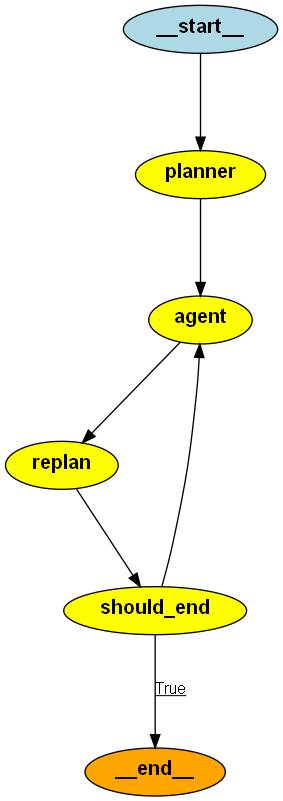

In [28]:
from IPython.display import Image

Image(app.get_graph(xray=True).draw_png())

And the Agent can be broken down into the following image:

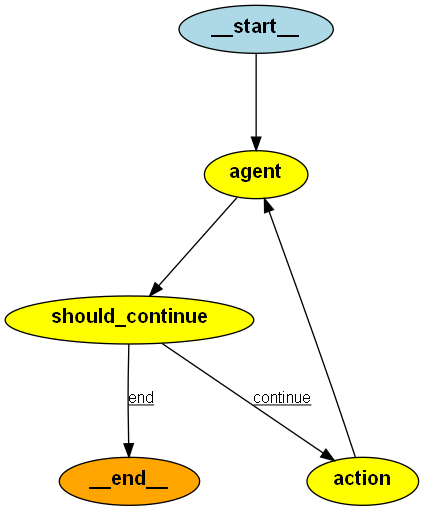

In [26]:
Image(agent_executor.get_graph().draw_png())